In [1]:
# Imports
import add_to_syspath

import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform
from lucid.modelzoo import vision_base

from audiomnist.models import alexnet
from audiomnist.models.alexnet_inference import build_model
from audiomnist.train.alexnet import get_epoch_checkpoint

from tensorflow.keras import optimizers

In [2]:
K.set_learning_phase(0)
model = build_model()
ckpt = get_epoch_checkpoint("../models/alexnet2", 15)
model.load_weights(ckpt)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7ffef3371f28> and <tensorflow.python.keras.layers.core.Dense object at 0x7ffef3371e10>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7ffef3371f28> and <tensorflow.python.keras.layers.core.Dense object at 0x7ffef3371e10>).


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 55, 55, 96)        11712     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 27, 27, 96)        384       
_________________________________________________________________
conv2 (Conv2D)               (None, 23, 23, 256)       614656    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 11, 11, 256)       0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 11, 11, 256)       1024      
_________________________________________________________________
conv3 (Conv2D)               (None, 9, 9, 384)         885120    
__________

In [3]:

with K.get_session().as_default():
    vision_base.Model.save(
        save_url="../models/alexnet_lucid/frozen_graph_inference.pb",
        input_name='conv1_input',
        image_shape=[227,227,1],
        output_names=['dense3/Softmax'],
        image_value_range=[0,255]
    )

Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes


Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes


Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph


Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph


Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants


Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants


INFO:tensorflow:Froze 24 variables.


INFO:tensorflow:Froze 24 variables.


INFO:tensorflow:Converted 24 variables to const ops.


INFO:tensorflow:Converted 24 variables to const ops.


In [2]:
K.set_learning_phase(0)
model = vision_base.Model.load("../models/alexnet_lucid/frozen_graph_inference.pb")

In [6]:
model.show_graph()

512 0.0


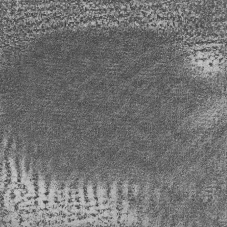

In [6]:
_ = render.render_vis(model, "conv5/Relu:0", param_f=lambda : param.color.to_valid_rgb(param.spatial.naive((1,227,227,1))))